- Load files

In [1]:
import pandas as pd

image_data = pd.read_csv('/kaggle/input/test-rsna-2024/image_test_rsna_2024_results.csv')
sample_submission = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')

In [2]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_path         97 non-null     object 
 1   predicted_class   97 non-null     object 
 2   confidence_score  97 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.4+ KB


In [3]:
image_data.shape

(97, 3)

In [4]:
sample_submission.shape

(25, 4)

- Remove the 'predicted_class' column . This project just need confident score & filename .

In [5]:
data = image_data.drop(columns=['predicted_class'])

- Extract the file number from the 'file_path' column

In [6]:
data['file_number'] = data['file_path'].str.extract(r'(\\|/)(\d{8})')[1]
data = data.drop(columns=['file_path'])

- A confidence score of 60% or higher is often used as a threshold to consider a classification as "true" / reliable for the aim for project classify lumbar spine degenerative conditions

- Map confidence scores into categories

In [7]:
def map_confidence(score):
    if score <= 0.3:
        return 'Very Uncertain'
    elif score <= 0.5:
        return 'Uncertain'
    elif score <= 0.75:
        return 'Moderate'
    elif score <= 0.9:
        return 'High'
    else:
        return 'Very High'

data['confidence_category'] = data['confidence_score'].apply(map_confidence)

- Visualize Percentage of Confidence Categories

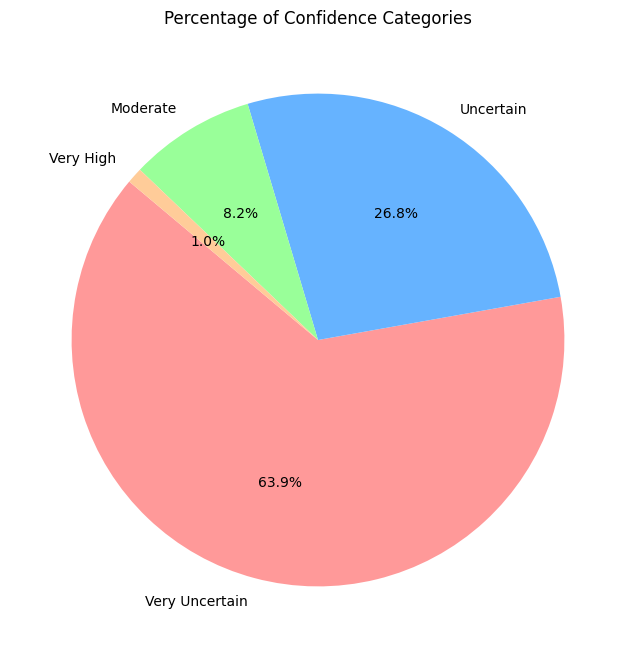

In [8]:
import matplotlib.pyplot as plt

# Calculate the percentage of each confidence category
category_counts = data['confidence_category'].value_counts()
category_percentages = (category_counts / category_counts.sum()) * 100

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Percentage of Confidence Categories')
plt.show()

- From results :

1. Very Uncertain is 69% . The image quality is likely very poor . It might be extremely blurry, too dark, or heavily distorted

2. Uncertain is 26.8% . The image quality may have moderate quality issues.

3. Moderate is 8.2% . The image quality some clear characteristics of the target image.

4. Very High is 1.0% . The image quality is perfectly visible, well-lit, and photographed from an ideal angle .

- Binarize the confidence score into two categories: 0 for <= 0.5 and 1 for > 0.5

In [9]:
data['confidence_binarized'] = (data['confidence_score'] > 0.5).astype(int)
data

,confidence_score,file_number,confidence_category,confidence_binarized
0,0.244174,44036939,Very Uncertain,0
1,0.250831,44036939,Very Uncertain,0
2,0.500476,44036939,Moderate,1
3,0.208484,44036939,Very Uncertain,0
4,0.134647,44036939,Very Uncertain,0
...,...,...,...,...
92,0.225739,44036939,Very Uncertain,0
93,0.286393,44036939,Very Uncertain,0
94,0.635892,44036939,Moderate,1
95,0.292019,44036939,Very Uncertain,0


In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'confidence_category' column
data['confidence_category_encoded'] = label_encoder.fit_transform(data['confidence_category'])

- Setting up features (X) and target variable (y)

In [11]:
X = data[['confidence_category_encoded']]
y = data['confidence_binarized']

- Train test split

In [12]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train, X_test, y_train, y_test

(    confidence_category_encoded
 33                            1
 9                             3
 80                            3
 11                            1
 65                            3
 ..                          ...
 60                            3
 71                            3
 14                            1
 92                            3
 51                            3
 
 [72 rows x 1 columns],
     confidence_category_encoded
 62                            3
 40                            1
 93                            3
 18                            3
 81                            3
 83                            3
 64                            3
 42                            3
 10                            0
 0                             3
 31                            0
 75                            0
 47                            2
 26                            1
 44                            3
 4                             3
 22              

- Train Model with Neural Network KFold

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import numpy as np


# Initialize the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, random_state=42)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store log loss for each fold
logloss_scores = []

# Perform Stratified K-Fold Cross Validation
for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Train the model
    nn_model.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    y_val_pred_proba = nn_model.predict_proba(X_val_fold)

    # Calculate log loss
    logloss = log_loss(y_val_fold, y_val_pred_proba)
    logloss_scores.append(logloss)

# Average log loss across all folds
average_logloss = np.mean(logloss_scores)

average_logloss

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

0.1919476286058693

- Save the trained neural network model to a .pkl file

In [14]:
import joblib

joblib.dump(nn_model, 'rsna_2024_model.pkl')

['rsna_2024_model.pkl']

- Predicted score after trained

In [15]:
y_val_pred_proba

array([[0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.80464419, 0.19535581],
       [0.80464419, 0.19535581],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.91836727, 0.08163273],
       [0.80464419, 0.19535581],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.80464419, 0.19535581],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.96934976, 0.03065024],
       [0.6489952 , 0.3510048 ]])